# Causes and Airlines of Delayed Flights on December 2008
## by Thais Ruiz

## Investigation Overview

The objective of this analysis is to determine which airlines had more flight delays and what were the delay causes for flight operations on December 2008.

## Dataset Overview

The (domestic) flights dataset is comprised by four main datasets: on time, delayed, cancelled and diverted. The last two were removed since their data was not relevant for the investigation.

A flight is considered delayed when its arrival delay is longer than 15 minutes.

The data consisted of 524,747 domestic flights with information on airlines, origin/destination cities, scheduled and actual arrival/departure times, delays time/causes and cancellation/divert status.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
from plotly.offline import init_notebook_mode, iplot
from collections import Counter

%matplotlib inline

init_notebook_mode(connected=True) # send Plotly output to notebook

# To force resize
plt.rcParams['figure.figsize'] = [15, 5]

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the datasets into pandas dataframes
flights_2008 = pd.read_csv('Datasource/2008.csv')
airports = pd.read_csv('Datasource/L_AIRPORT.csv')

In [3]:
# Subset of domestic flights operations on Dec-2008
flights_0812 = flights_2008[(flights_2008.Month==12)]

# Remove columns: Year, Month, TaxiIn, TaxiOut, TailNum, ActualElapsedTime, CRSElapsedTime, AirTime, Distance 
flights_0812 = flights_0812[['DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime',\
                             'UniqueCarrier', 'FlightNum', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'Cancelled',\
                             'CancellationCode', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay',\
                             'SecurityDelay', 'LateAircraftDelay']]

In [4]:
# Merge origin/destination description fields from airport dataframe to flights_0812 dataframe
flights_0812 = pd.merge(flights_0812, airports, left_on='Origin', right_on='Code').drop('Code', axis=1)
flights_0812.rename(columns = {'Description':'OriginDescription'}, inplace = True)

flights_0812 =  pd.merge(flights_0812, airports, left_on='Dest', right_on='Code').drop('Code', axis=1)
flights_0812.rename(columns = {'Description':'DestDescription'}, inplace = True)

In [5]:
# Change columns to category type
categories_cols = ['DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest']

for col in categories_cols:
    flights_0812[col] = flights_0812[col].astype('category')

In [6]:
# Remove cancelled and diverted flights data
cancelled = flights_0812.Cancelled==1
diverted  = flights_0812.Diverted==1

flights = flights_0812[(~cancelled) & (~diverted)].drop(['Cancelled', 'CancellationCode', 'Diverted'], axis=1)

In [7]:
# Subset On Time and Delayed flights
on_time = flights.ArrDelay<15
delayed = flights.ArrDelay>=15 # A flight is considered delayed if its (arrival) delay is over 15 minutes (inclusive)

delayed_flights = flights[delayed]

# Removing delay causes columns on On Time flights dataset
delay_cols = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
on_time_flights = flights[on_time].drop(delay_cols, axis=1)

## Delayed Status Proportion of Domestic Flights

On December 2008, out of 524,747 flights which were on track, 356,100 (67.86%) were on time  and 168,647 (32.14%) delayed. This last subset is split in 'large' and 'medium', depending if the delays are or not longer than 156.5 minutes (~2.5 hours) as corresponding.
The 'large' delays portion represents the  arrival delays outliers.

In [8]:
def plot_pie(sizes, colors, labels, title, explode=None):
    patches, texts, autotexts = plt.pie(sizes, autopct='%.2f%%', startangle=90, colors=colors,\
                                        labels=labels, explode=explode)
    plt.axis('square') # equal aspect ratio ensures that pie is drawn as a circle
    plt.title(title + '\n', fontsize=14);

In [9]:
# Calculate the limit where values would be considered outlier
Q1, median, Q3 = np.percentile(delayed_flights.ArrDelay, [25, 50, 75])
IQR = Q3 - Q1
high_val = Q3 + 1.5 * IQR # top whisker in a boxplot

# Count Outliers and calculate their proportion
num_outliers  = delayed_flights[delayed_flights.ArrDelay>high_val].shape[0]
total_delayed = delayed_flights.shape[0]
outliers_prop = num_outliers*100 / total_delayed

medium_delayed = delayed_flights[delayed_flights.ArrDelay<=high_val]

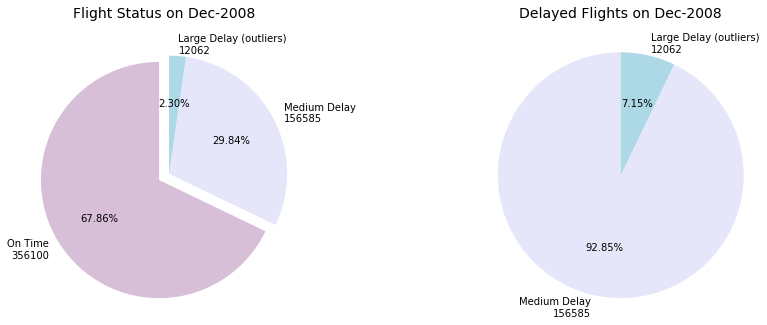

In [10]:
# Pie Chart plotting

fig= plt.figure()

# Proportion of flight statuses
ax1 = plt.subplot(1,2,1)

sizes   = [len(on_time_flights), len(medium_delayed), num_outliers]
colors  = ['thistle','lavender', 'lightblue']
labels  = ['On Time\n' + str(sizes[0]), 'Medium Delay\n' + str(sizes[1]), 'Large Delay (outliers)\n' + str(sizes[2])]
title   = 'Flight Status on Dec-2008'
explode = (0.1, 0, 0)

plot_pie(sizes, colors, labels, title, explode=explode)

ax2 = plt.subplot(1,2,2)

sizes  = [total_delayed-num_outliers, num_outliers]
labels = ['Medium Delay\n' + str(sizes[0]), 'Large Delay (outliers)\n' + str(sizes[1])]
title  = 'Delayed Flights on Dec-2008'

plot_pie(sizes, colors[-2:], labels, title)

## Sum of Delays by Cause totals Arrival Delays

Arrival delays is comprised by the sum of delays caused by:

- **Air Carrier**: The cause of the delay was due to circumstances within the airline's control (e.g. maintenance or crew problems, aircraft cleaning, baggage loading, fueling, etc.).

- **Extreme Weather**: Significant meteorological conditions (actual or forecasted) that, in the judgment of the carrier, delays or prevents the operation of a flight such as tornado, blizzard or hurricane. Snowstorms, thunderstorms, hail, tornadoes, low clouds/fog, wind

- **National Aviation System (NAS)**: Delays that refer to a broad set of conditions, such as non-extreme weather conditions, airport operations, heavy traffic volume, and air traffic control.

- **Late-arriving aircraft**: A previous flight with same aircraft arrived late, causing the present flight to depart late.

- **Security**: Delays caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.

#### How each of these causes contribute to arrival delays per their average time delay?

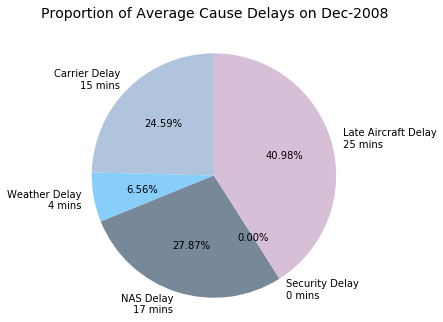

In [11]:
# Pie chart plotting

mean_car_del = int ( delayed_flights.CarrierDelay.mean() )
mean_wea_del = int ( delayed_flights.WeatherDelay.mean() )
mean_nas_del = int ( delayed_flights.NASDelay.mean() )
mean_sec_del = int ( delayed_flights.SecurityDelay.mean() )
mean_lat_del = int ( delayed_flights.LateAircraftDelay.mean() )


sizes  = [mean_car_del, mean_wea_del, mean_nas_del, mean_sec_del, mean_lat_del]
colors = ['lightsteelblue', 'lightskyblue', 'lightslategray', 'black', 'thistle']
labels = [
            'Carrier Delay\n' + str(sizes[0]) + ' mins',\
            'Weather Delay\n' + str(sizes[1]) + ' mins', \
            'NAS Delay\n' + str(sizes[2]) + ' mins',\
            'Security Delay\n' + str(sizes[3]) + ' mins',\
            'Late Aircraft Delay\n' + str(sizes[4]) + ' mins' 
         ]
title  = 'Proportion of Average Cause Delays on Dec-2008'

plot_pie(sizes, colors, labels, title)

## Frequency of Delay Causes per Airline

Per the proportion of average time delays, the main contributing cause to arrival delays is late arriving aircraft, followed by NAS and weather, which are close in proportion. The least contributing cause is security.

But per the relative frequency of causes per each airline, for most of them, NAS is the most frequent cause of delays, followed by late-arriving aircraft and carrier. Weather has low frequency proportion, and security is almost imperceptible.

In [12]:
# Melt delay causes to create a category 'CauseDelay'
id_vars = list(delayed_flights.columns[:-7]) + list(delayed_flights.columns[-2:])

delayed = pd.melt(delayed_flights, id_vars=id_vars, value_vars=delay_cols, var_name='CauseDelay', value_name='Delay')
delayed = delayed[delayed.Delay>0] # subset with causes delays time > 0 minutes
delayed['CauseDelay'] = delayed['CauseDelay'].str[:-5] # remove the ending 'Delay' from 'Cause' strings


# Change columns to category type
categories_cols = ['DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'CauseDelay']

for col in categories_cols:
    delayed[col] = delayed[col].astype('category')

In [13]:
# Dictionary of airlines codes and names
Airlines = {'9E':'Endeavor', 'AA':'American', 'AS':'Alaska', 'B6':'JetBlue', 'CO':'Continental', 'DL':'Delta', \
            'EV':'ExpressJet', 'F9':'Frontier', 'FL':'AirTran', 'HA': 'Hawaiian', 'MQ':'Envoy', 'NW':'Northwest',\
            'OH':'PSA', 'OO':'SkyWest', 'UA':'United', 'US':'US', 'WN': 'Southwest', 'XE':'ExpressJet (1)', 'YV':'Mesa'}

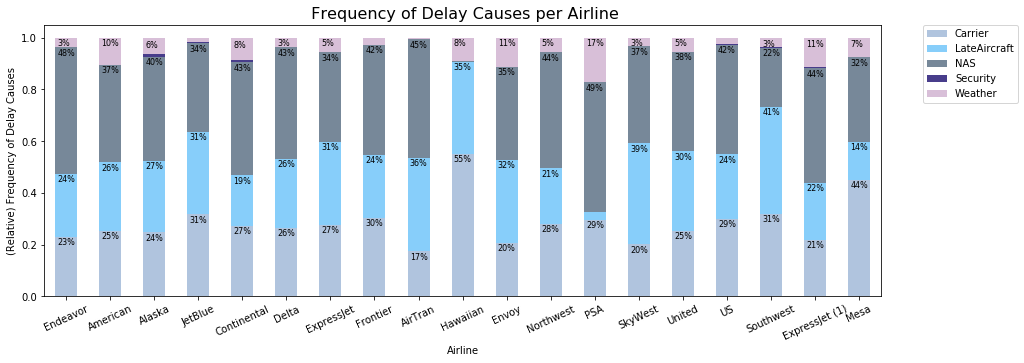

In [14]:
# Stacked Bar plotting

colors = ['lightsteelblue', 'lightskyblue', 'lightslategray', 'darkslateblue', 'thistle']

df_plot = delayed.groupby(['CauseDelay', 'UniqueCarrier']).size().reset_index().\
                            pivot(columns='CauseDelay', index='UniqueCarrier', values=0)   

del_by_airln = delayed.groupby('UniqueCarrier').size()

# Calculate proportion of delayed flight operations by airlines
df_plot_proportion = df_plot.div(del_by_airln, axis='index')


data_idx = df_plot_proportion.index

df_plot_proportion.plot.bar(stacked=True, color=colors);

plt.title( ' Frequency of Delay Causes per Airline', fontsize=16)
plt.xlabel('Airline')
plt.ylabel('(Relative) Frequency of Delay Causes')

xlocs, xlabels = plt.xticks()
xlabl = [Airlines[label.get_text()] for label in xlabels]
plt.xticks(xlocs, xlabl, rotation = 25);

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# Annotations
for idx in data_idx: 
    
    initial_height = 0

    for col in df_plot_proportion.columns:   # ['Carrier', 'LateAircraft', 'NAS', 'Security', 'Weather']   

        if col != 'Security':  
            value  = df_plot_proportion.loc[idx, col]
            text   = str( int( value * 100)) + '%'
            height = value + initial_height
            x_loc  = data_idx.get_loc(idx)

            if value > 0.03:
                plt.annotate(text, (x_loc - .2, height - .03), fontsize=8)
            
        initial_height = height


## Arrival Delay per Delay Causes

By exploring the impact of delay causes on arrival delays when they happen, the cause that produces the most delay on arrivals is weather, followed by the late-arriving aircraft, carrier, NAS and the one that produces the least delay when it occurs is security.

It is important to notice that even though weather has the most impact on delays when it happens, this is the second least frequent delay cause, as shown in the previous plot.


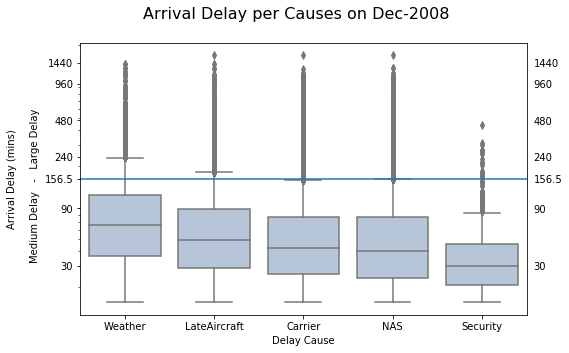

In [15]:
# Box Plotting 

fig = plt.figure(figsize = [8, 5]);
fig.suptitle('Arrival Delay per Causes on Dec-2008', fontsize=16)

order = delayed.groupby('CauseDelay')['ArrDelay'].median().sort_values(ascending=False).index

# On log y-scale
sb.boxplot(data=delayed, x='CauseDelay', y=delayed.ArrDelay, color='lightsteelblue', order=order);
plt.yscale('log')
plt.xlabel('Delay Cause')
plt.ylabel('Arrival Delay (mins)\n\nMedium Delay   -   Large Delay    ')
plt.axhline(high_val)

yticks = [30, 90, high_val, 240, 480, 960, 1440]
plt.yticks(yticks, yticks);
ax2.yaxis.set_minor_locator(plt.NullLocator());

# show tick labels in the right y-axis
plt.tick_params(axis='y', which='both', labelleft='on', labelright='on')

## Ranking of Delay Causes

(From most to least)

- **Per their contributing time to arrival delays:** late-arriving aircraft, NAS, carrier, weather, security
- **Per their frequency:** NAS, late-arriving aircraft, carrier, weather, security
- **Per their impact on arrival delays:** weather, late-arriving aircraft, carrier, NAS, security

## Proportion of Delayed Flights per Airline

Per the relative frequency of delayed flights over total of flight operations per airline, PSA is the airline that has more delayed flights (41%). Per the 'Frequency of Delay Causes per Airline' chart, this is the airline most frequently affected by weather conditions (17%).

Although Southwest is the airline that carried more flight operations (~95k), doubled a little more in number their next two: American and Skywest, it is not the one with more delayed flights. Even American, that is the second airline with more flight operations (~46k), it is allocated as the antepenultime in the ranking of delayed flights proportion.

In [16]:
def plot_barh(data, groupby, color, height, label, order=None):
    
    if order is None:
        gb_data = data.groupby(groupby).size().sort_values().reset_index()
    else:
        gb_data = data.groupby(groupby).size().reindex(order).reset_index()
    
    gb_data_idx = gb_data.index
    ax = plt.barh( gb_data_idx, gb_data[0], color=color, label=label, height=height );
    
    plt.xlabel('\n Number of Flight Operations', fontsize=12)
    plt.ylabel('Airlines', fontsize=12)

    xtk_locs = [5000*(i+1) for i in np.arange(0,19)]
    xtk_lbls = ['{}k'.format(str(i)[:-3]) for i in xtk_locs]
    plt.xticks(xtk_locs, xtk_lbls)

    ytk_lbls = [ Airlines[gb_data.UniqueCarrier[idx]] for idx in gb_data_idx ]
    plt.yticks(gb_data_idx, ytk_lbls);
              
    return ax, gb_data

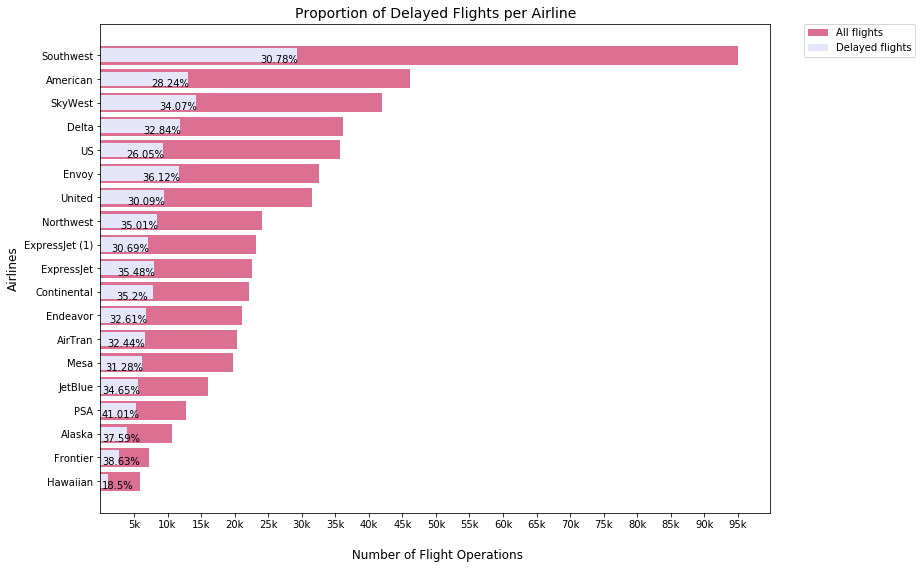

In [17]:
# Bar plotting
plt.figure(figsize=[12,9]);

ax1, gb_data1 = plot_barh(flights, 'UniqueCarrier', 'palevioletred', .8, 'All flights');
ax2, gb_data2 = plot_barh(delayed_flights, 'UniqueCarrier', 'lavender', .6, 'Delayed flights', order=gb_data1.UniqueCarrier);

plt.title('Proportion of Delayed Flights per Airline', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# Annotations in Delayed flights bars
ax1_patch_widths = [p.get_width() for p in ax1.patches]
ax2_patch_widths = [p.get_width() for p in ax2.patches]

texts=[ str(round(ax2_patch_widths[idx]*100 / ax1_patch_widths[idx],2))+'%' for idx in np.arange(0, len(Airlines)) ]

# Annotation for the top bars
for p in ax2.patches[5:]:
    idx = ax2.patches.index(p)
    plt.annotate(texts[idx], (p.get_width()-5500, p.get_y()))

# Annotation for the (5) bottom bars
for p in ax2.patches[:5]:
    idx = ax2.patches.index(p)
    plt.annotate(texts[idx], (200, p.get_y()))


### Arrival Delay per Airline
The median of the arrival delay for the airlines is in the range between 33-50 minutes and the third quartile between 50-100 minutes.

Per the median, the three worst performers airlines are JetBlue, ExpressJet(1) and Mesa; and the three best are Hawaiian, AirTran and Delta.

Northwest, Envoy and American Airlines are the carriers with longer large delays.

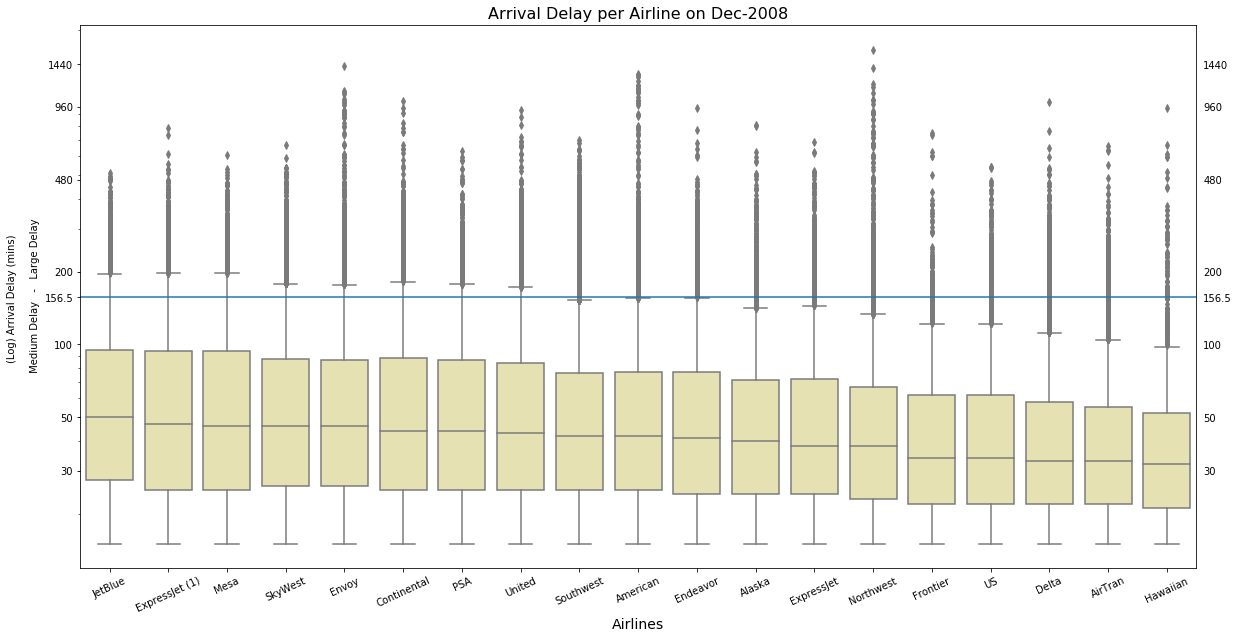

In [18]:
# Box Plotting 

fig = plt.figure(figsize=(20, 10))

order = delayed_flights.groupby('UniqueCarrier')['ArrDelay'].median().sort_values(ascending=False).index
sb.boxplot(data=delayed_flights, x='UniqueCarrier', y=delayed_flights['ArrDelay'], color='palegoldenrod', order=order);
plt.yscale('log')
plt.title('Arrival Delay per Airline on Dec-2008', fontsize=16)
plt.xlabel('Airlines', fontsize=14)
plt.ylabel('(Log) Arrival Delay (mins) \n\n Medium Delay   -   Large Delay')

xlocs, xlabels = plt.xticks()
xlabl = [Airlines[label.get_text()] for label in xlabels]
plt.xticks(xlocs, xlabl, rotation = 25);
yticks = [30, 50, 100, high_val, 200, 480, 960, 1440]
plt.yticks(yticks, yticks);

# show tick labels in the right y-axis
plt.tick_params(axis='y', which='both', labelleft='on', labelright='on')

plt.axhline(high_val); # line in the value of ~2.5 hours, which divide the delayed dataset in medium and large delays

## Frequency of Delay Causes per Airline

Since the majority of delay causes are not within any airline's control, the airline's performance could be measured by the frequency of their delays caused by carrier. The 'Frequency of Delay Causes by Airline' chart, shows this performance.

Per the relative frequency of delays by carrier, Hawaiian is the worst performer, it is not anymore the best as seen in the previous plots. Mesa is the following worst, as it is also placed among the worst ones per the median of arrival delays.

Per the relative frequency of delays by carrier, the top performers are AirTran and now SkyWest; SkyWest is the placed as the 4th worst per the median of arrival delays, contrary to AirTran which is the second best performer by this median. 

## Ranking of Airlines
(From best to worst)

- **Per proportion of delayed flights:** Hawaiian (18.5%), US (26%) and American (28%), ..., JetBlue (35%), NorthWest (35%), Continental (35%), ExpressJet (36%), Envoy (36%), Alaska(38%), Frontier (39%) and PSA (41%).
- **Per the median of the arrival delay:** Hawaiian, AirTran, Delta, US, Frontier, ..., PSA, Continental, Envoy, Skywest, Mesa, Expressjet(1) and JetBlue
- **Per the relative frequency of delays by carrier:** AirTran (17%), SkyWest (20%), Envoy (21%), ExpressJet(1) (22%), Endeavor (23%), ..., PSA (30%), US (30%), Frontier (30%), JetBlue (32%), Southwest (32%), Mesa (44%) and Hawaiian (55%).